<a href="https://colab.research.google.com/github/fachiny17/machine_learning/blob/main/tensorflow_course/07_milestone_project_1_food_vision_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 1: Food Vision Big

## Check GPU

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-5956c273-61b8-ec40-9021-02fbde980b57)


## Get helper functions

In [2]:
# Download helper functions script
!wget https://github.com/mrdbourke/tensorflow-deep-learning/raw/refs/heads/main/extras/helper_functions.py

--2025-11-18 12:53:41--  https://github.com/mrdbourke/tensorflow-deep-learning/raw/refs/heads/main/extras/helper_functions.py
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py [following]
--2025-11-18 12:53:41--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-11-18 12

In [3]:
# Import series of helper functions for the notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Use TensorFlow Datasets to download data

## Use TensorFlow Datasets to Download Data
If you want to get an overview of TensorFlow (TFDS), read the guide: https://www.tensorflow.org/datasets/overview

In [4]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

In [5]:
# List all available datasets
datasets_list = tfds.list_builders() # get all available datasets in TFDS
#datasets_list
print("food101" in datasets_list)

True


In [6]:
import tensorflow_datasets as tfds
print(tfds.__version__)


4.9.9


In [7]:
# Load in the data (takes 5-6 minutes)
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True, # data gets returned in tuple form (data, label)
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.JPEYON_2.0.0/food101-train.tfrecord*...:   0%|         …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.JPEYON_2.0.0/food101-validation.tfrecord*...:   0%|    …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


## Exploring the Food101 data from TensorFlow Datasets

In [8]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [9]:
# Get the class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [10]:
# Take one sample of the train data
train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)

In [11]:
# What does one sample of our training data look like?
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [12]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape},
  Image datatype: {image.dtype},
  Target class from Food101 (tensor form): {label},
  Class name (str form): {class_names[label.numpy()]}
  """)


  Image shape: (512, 512, 3),
  Image datatype: <dtype: 'uint8'>,
  Target class from Food101 (tensor form): 49,
  Class name (str form): grilled_cheese_sandwich
  


In [13]:
# What does our image tensor from TFDS's Food101 look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[239, 217, 157],
        [244, 222, 162],
        [247, 227, 168],
        ...,
        [119, 104,  73],
        [111,  95,  70],
        [105,  89,  66]],

       [[233, 212, 149],
        [239, 218, 155],
        [243, 223, 162],
        ...,
        [117, 102,  71],
        [108,  92,  67],
        [101,  85,  62]],

       [[227, 206, 139],
        [234, 213, 146],
        [238, 219, 153],
        ...,
        [117, 100,  70],
        [108,  91,  65],
        [101,  83,  59]],

       ...,

       [[ 35,   7,  19],
        [ 35,   7,  19],
        [ 36,   8,  20],
        ...,
        [198, 181, 127],
        [196, 179, 125],
        [193, 176, 122]],

       [[ 34,   6,  18],
        [ 34,   6,  18],
        [ 35,   7,  19],
        ...,
        [200, 183, 129],
        [201, 184, 130],
        [198, 181, 127]],

       [[ 33,   5,  17],
        [ 34,   6,  18],
        [ 35,   7,  19],
        ...,
        [203, 186, 13

In [14]:
# What are the min and max values of our image tensor?
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

### Plot an image from TensorFlow Datasets

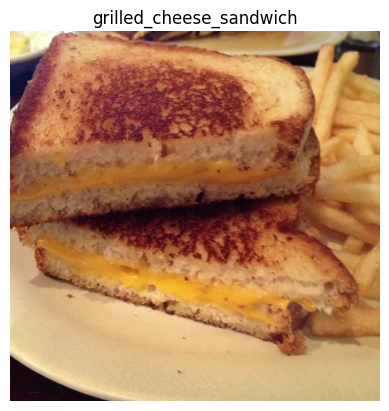

In [15]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()]) # Add title to image to verify the label is associated with the right image
plt.axis(False);

## Create preprocessing fuctions for our data

In [16]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype from 'uint8' -> 'float32' and reshapes image
  to [img_shape, img_shape, colour_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape]) # reshape target image
  # image = image/255. # scale image values (not required with EfficientNetBX models from tf.keras.applications)
  return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [17]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}..., \nShape: {image.shape}, \nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}..., \nShape: {preprocessed_img.shape}, \nShape: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[239 217 157]
  [244 222 162]
  [247 227 168]
  ...
  [119 104  73]
  [111  95  70]
  [105  89  66]]

 [[233 212 149]
  [239 218 155]
  [243 223 162]
  ...
  [117 102  71]
  [108  92  67]
  [101  85  62]]]..., 
Shape: (512, 512, 3), 
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[238.7704   217.41327  155.4847  ]
  [242.83673  222.83673  162.55101 ]
  [240.85713  220.20918  164.2143  ]
  ...
  [131.28564  118.28565   75.7806  ]
  [123.88257  109.81113   75.09689 ]
  [106.698746  90.698746  66.4131  ]]

 [[232.16325  212.09183  141.37755 ]
  [238.86224  219.86224  151.07654 ]
  [239.94388  221.08673  155.87245 ]
  ...
  [127.49998  112.49998   71.07145 ]
  [122.63767  106.56623   72.852   ]
  [105.83142   88.47424   63.1886  ]]]..., 
Shape: (224, 224, 3), 
Shape: <dtype: 'float32'>


## Batch and prepare datasets
We're now going to make our data input pipeline run really fast.

For more resources on this, I'd highly going through the following guide: https://www.tensorflow.org/guide/data_performance

In [18]:
# Map preprocessing function to training (and parallelize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=32).prefetch(tf.data.AUTOTUNE)

In [19]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

Hey, TensorFLow, map this preprocessing function (`preprocess_img`) across our training dataset, then shuffle a number of elements and then batch them together and finally make sure you prepare new batches (prefetch) whilst the model is looking through (finding patterns) the current batch.

 ## Create modelling callbacks

In [20]:
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save a model's progress during training
checkpoint_path = "model_checkpoints/cp.weights.h5" # Changed filepath to end with .weights.h5
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_acc",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0) # don't print whether or not model is being saved

## Setup mixed precision training

In [21]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16") # set global data policy to mixed precision

In [22]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-5956c273-61b8-ec40-9021-02fbde980b57)


In [23]:
!nvidia-smi

Tue Nov 18 13:06:14 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P0             26W /   70W |     104MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [24]:
mixed_precision.global_policy()

<DTypePolicy "mixed_float16">

## Build feature extraction model

In [25]:
from tensorflow.keras import layers

# Create a base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [26]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 101)            │       129,381 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_float32 (Activation)    │ (None, 101)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

## Checking layer dtype policies (are we using mixed precision?)

In [31]:
# Check the dtype_policy attribute of layers in our model
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <DTypePolicy "mixed_float16">
efficientnetb0 False float32 <DTypePolicy "mixed_float16">
global_average_pooling2d True float32 <DTypePolicy "mixed_float16">
dense True float32 <DTypePolicy "mixed_float16">
softmax_float32 True float32 <DTypePolicy "float32">


In [47]:
# Check the dtype_policy attributes of layers in efficientnetbo
for layer in model.layers[1].layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer False float32 <DTypePolicy "mixed_float16">
rescaling False float32 <DTypePolicy "mixed_float16">
normalization False float32 <DTypePolicy "mixed_float16">
rescaling_1 False float32 <DTypePolicy "mixed_float16">
stem_conv_pad False float32 <DTypePolicy "mixed_float16">
stem_conv False float32 <DTypePolicy "mixed_float16">
stem_bn False float32 <DTypePolicy "mixed_float16">
stem_activation False float32 <DTypePolicy "mixed_float16">
block1a_dwconv False float32 <DTypePolicy "mixed_float16">
block1a_bn False float32 <DTypePolicy "mixed_float16">
block1a_activation False float32 <DTypePolicy "mixed_float16">
block1a_se_squeeze False float32 <DTypePolicy "mixed_float16">
block1a_se_reshape False float32 <DTypePolicy "mixed_float16">
block1a_se_reduce False float32 <DTypePolicy "mixed_float16">
block1a_se_expand False float32 <DTypePolicy "mixed_float16">
block1a_se_excite False float32 <DTypePolicy "mixed_float16">
block1a_project_conv False float32 <DTypePolicy "mixed_float16"

In [48]:
mixed_precision.global_policy()

<DTypePolicy "mixed_float16">